In [1]:
from Interval_v4 import *
import cv2
import json
# import concurrent.futures
# from itertools import repeat
from IPython.display import clear_output

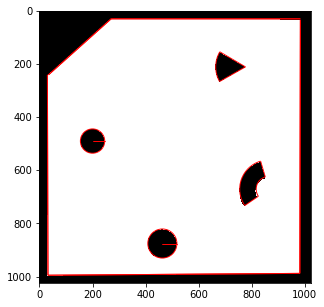

In [2]:
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)
for obstacle in obstacles:
    obstacle.draw(ax,'red')
plt.show()
    

In [42]:
### no inheritance
class Robot:
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    Nr = 5
    Ntheta = 5

    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        
    @property
    def interval(self):
        theta1 = self.yaw - (self.wi - self.wj)*self.Δt
        theta2 = self.yaw + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/np.sin(1e-6+(theta2-theta1)/2)
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return Interval(nu1,nu2,theta1,theta2,origin)
    
    def __repr__(self):
        return f"Robot at {self.x_bot},{self.y_bot},{self.yaw}"
    
    def set_path(self,path):
        self.path = path
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        
        for obstacle in self.obstacles:
            I = self.interval
            #print('obstacle', obstacle)
            J = I.fast_analysis(obstacle)
            #print("det", J)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J       
        #print("obs", Js)
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.ceil(((self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+   
            vws.append([v,-1*w])
        for i in range(num_samples):
            w = i*min_angle*self.Δt ### sus I.theta1+
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,traj_v,traj_w,ax):
        """
        gives good v,w given bad v,w from the tracker
        """
#         w = w*np.random.uniform(-1,1)
        I = self.interval
        vws = self.generate_vw()
        comps = set([])
        if not len(Js) == 0:
            
            for J in Js:
                comps.update(I.complement(J)) 
                #J.draw(ax,"green")
            for comp in comps:
                comp.draw(ax,'magenta')
                if comp.r2 == I.r2:
                    continue
                else:    
                    for i,[v,w] in enumerate(vws):
                        if self.yaw+w*self.Δt<= comp.theta2+np.arcsin(self.radius/(I.r2-self.radius))+2*np.pi/24 and self.yaw+w*self.Δt>=comp.theta1-np.arcsin(self.radius/(I.r2-self.radius))-2*np.pi/24:
                            #np.pi/24 is min angle
                            vnew = ((comp.r2-comp.r1-2*self.radius)/self.Δt)
                            if v>vnew and vnew>=0:
                                vws[i][0] = vnew
            vwes = np.array(vws)[::-1]
            #idr = np.random.choice(range(len(vwes)))
#             ws = vwes[:,1]
#             traj_ws = traj_w*np.ones_like(ws)
#             diff = (ws-traj_ws-np.pi/3)**2
# #     # #         print(vws)
# #             print(diff)
#             vwn = vwes[np.argmin(diff)]
            is_collide = True
            v_max,ws = vwes[np.argmax(vwes[:,0])]
        
            #w_x = np.array([abs(w-traj_w) for v,w in vwes])
            
            vwn = np.array([v_max/2,ws])
    #         print("vwn = ",vwn)
            #return vwes[idr] 
    #         print(vwes)
        else:
            max_w = abs(self.wi-self.wj)
            traj_w = traj_w if abs(traj_w)<max_w else max_w*np.sign(traj_w)
            vwn = np.array([traj_v,traj_w])
            is_collide = False
            print("no collision ")
            print("applied velocity = ", vwn)
        
        return vwn,is_collide
            
        
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         pose = [self.x_bot,self.y_bot,self.yaw]
#         Js = self.collision_detection()
#         v,w = self.collision_avoidance(Js)
#         self.x_bot += v*np.cos(self.yaw)*self.Δt
#         self.y_bot += v*np.sin(self.yaw)*self.Δt
#         self.yaw += w*self.Δt
# #         self.vj = v
# #         self.wj = w
#         super(Robot,self).__init__(*self.params)
        
        
#             #cook something that creates new v,w which do not crash into the obstacles 
#         #Robot(*pose,self.vi,self.vj,self.wi,self.wj)
#         return self
    def next_bot(self,traj_v,traj_w,ax):
        Js = self.collision_detection()
        vw,is_collide = self.collision_avoidance(Js,traj_v,traj_w,ax)
        v,w = vw
#         for J in Js:
#             J.draw(ax,'magenta')
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return self,is_collide
    def next_bots(self,ax):
        bots = []
        Js = self.collision_detection()
        for [v,w] in self.collision_avoidance(Js,ax):
            yaw = self.yaw + w*self.Δt
            x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
            y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
            bots.append(Robot(x_bot,y_bot,yaw,self.vi,self.vj,self.wi,self.wj))
            
#         v,w = self.collision_avoidance(Js,ax)
#         for J in Js:
#             J.draw(ax,'magenta')
        
#         self.yaw = yaw
#         self.x_bot = x_bot
#         self.y_bot = y_bot
        
        
#         vi = self.vi
#         vj = self.vj
#         wi = self.wi
#         wj = self.wj
        return bots
    def next_pose(self,v,w):
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        return self
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
#         for I in self.Is:
#             I.draw(ax,'green')
        self.interval.draw(ax,self.color)
        
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
        
# def correction(thetas):
#     tuts = []
#     tuts1 = []
#     for theta in thetas:
#         if theta>=0 and theta<= np.pi/2:
#             tuts.append(0)
#         if theta>=3*np.pi/2 and theta<= 2*np.pi:
#             tuts.append(1)
#         if theta>=np.pi/2 and theta<= np.pi:
#             tuts1.append(0)
#         if theta<=-1*np.pi/2 and theta>= -1*np.pi:
#             tuts1.append(1)    
            

#     if any(tuts) and not all(tuts):
#         return [(theta-2*np.pi if theta>=3*np.pi/2 else theta) for theta in thetas]
#     elif any(tuts1) and not all(tuts1):
#         return [(theta+2*np.pi if theta<=-1*np.pi/2 else theta) for theta in thetas]
#     else:
#         return thetas        
        
    
# def complement(I,J):
#     if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
#         return [I]
#     Is = []
#     if I.theta1 != J.theta1:
#         I1 = Interval(I.r1,I.r2,*correction([I.theta1,J.theta1]),I.origin)
#         Is.append(I1)
#         print("I1 = ",I1)
#     if J.theta1 != J.theta2:    
#         I2 = Interval(I.r1,J.r1,*correction([J.theta1,J.theta2]),I.origin)
#         Is.append(I2)
#         print("I2 = ",I2)
#     if J.theta2 != I.theta2:    
#         I3 = Interval(I.r1,I.r2,*correction([J.theta2,I.theta2]),I.origin)
#         Is.append(I3)
#         print("I2 = ",I2)
#     return Is       

In [6]:
aa = np.array([[4,4],[2,3],[44,6]]) - np.array([1,1]) # np.array([[0,4],[0,3],[44,0]])
aa

array([[ 3,  3],
       [ 1,  2],
       [43,  5]])

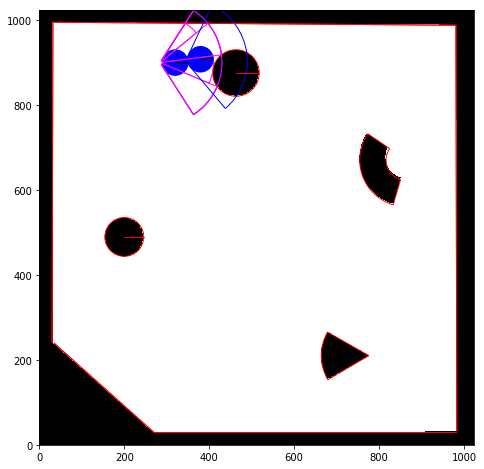

In [5]:

#robot = Robot(680,600,0,80,0,1.57,0)
#robot = Robot(800,800,0.5,100,0,1,0)
robot = Robot(320,900,0,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,800,4.2,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))

for i in range(1):

    
    pose = robot.next_bot(ax)

    
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

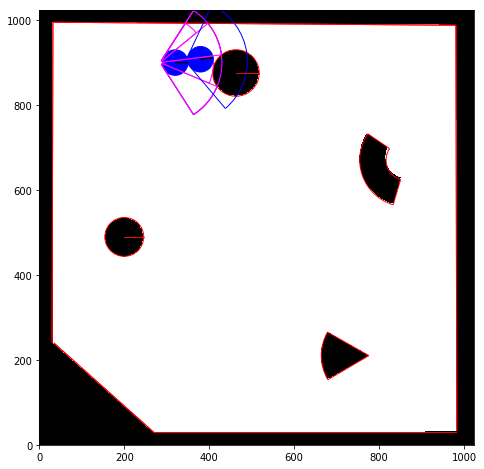

In [21]:

#robot = Robot(680,600,0,80,0,1.57,0)
#robot = Robot(800,800,0.5,100,0,1,0)
robot = Robot(320,900,0,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,800,4.2,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))

for i in range(1):

    
    pose = robot.next_bot(1,1,ax)

    
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

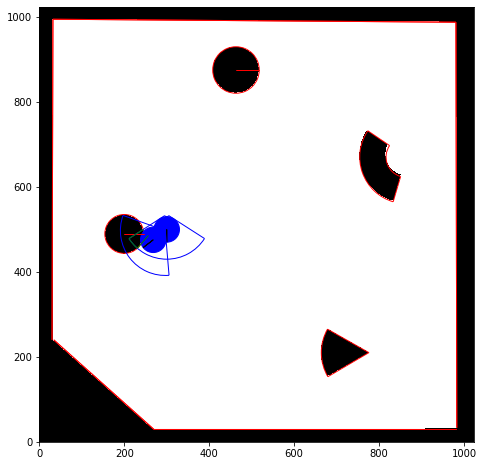

In [4]:

#robot = Robot(680,600,0,80,0,1.57,0)
#robot = Robot(800,800,0.5,100,0,1,0)
robot = Robot(300,500,-1.57,40,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,800,4.2,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))

for i in range(1):

    
    pose,is_collide = robot.next_bot(1,1,ax)

    
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

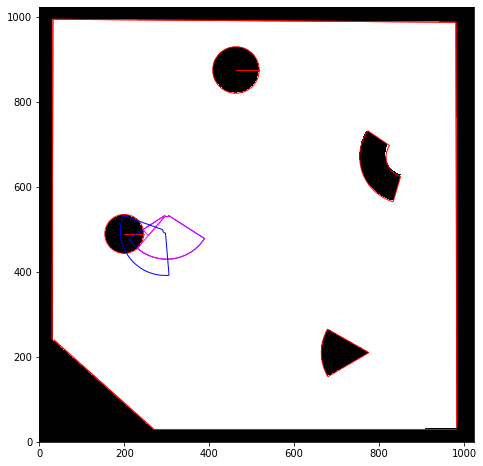

In [6]:

#robot = Robot(680,600,0,80,0,1.57,0)
#robot = Robot(800,800,0.5,100,0,1,0)
robot = Robot(300,500,-1.57,40,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,800,4.2,100,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
#robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))

for i in range(1):

    
    pose,is_collide = robot.next_bot(1,1,ax)

    
    #pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

run: 0


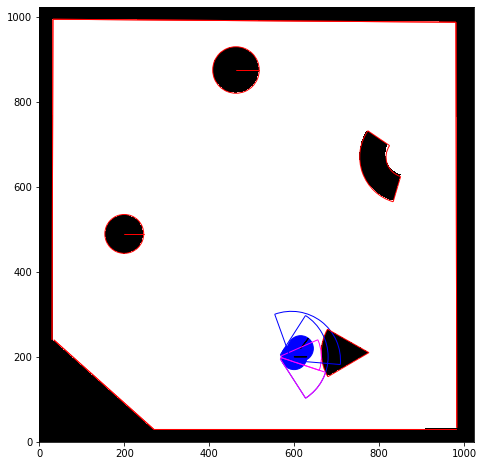

In [48]:

#robot = Robot(680,600,0,80,0,1,0)
#robot = Robot(800,800,0.5,100,0,1,0)
#robot = Robot(379.4084003997459, 907.8212642902986, 0.1308996938995747,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
#robot = Robot(900,700,5,100,0,1,0)
robot = Robot(600,200,6.284,50,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))
log = []
for i in range(1):

    
    pose,is_c = robot.next_bot(0,0,ax)
    
    print("run:",i)
    log.append(f'run {i} :'+repr(pose))
    pose.plot(ax)
    pose.plot_interval(ax)
    robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        

In [25]:
log


['run 0 :Robot at 875.528280271123,666.3436419610946,4.083702142702977',
 'run 1 :Robot at 903.8944988174457,570.4512144947807,5.0',
 'run 2 :Robot at 845.0861809162436,489.57116908411615,4.083702142702977',
 'run 3 :Robot at 873.4523994625663,393.6787416178023,5.0',
 'run 4 :Robot at 901.818618008889,297.78631415148845,5.0',
 'run 5 :Robot at 843.0103001076869,216.9062687408239,4.083702142702977',
 'run 6 :Robot at 871.3765186540096,121.01384127451004,5.0',
 'run 7 :Robot at 928.2657448644608,99.15206983924787,5.916297857297023',
 'run 8 :Robot at 1013.5489995023959,151.3705194366949,6.832595714594046',
 'run 9 :Robot at 1024.0384740533357,250.81885237217043,7.7488935718910685']

comp =  Interval(5.651830281584495,87.63642450078733,-0.9230938962243309,0.6331125501174292,(894.9865438991565, 212.94082323800623))
comp =  Interval(5.651830281584495,145.6518302815845,4.916297857297023,5.360091410955255,(894.9865438991565, 212.94082323800623))
run: 0
Interval(5.651830281584495,145.6518302815845,4.0,6.0,(940.8456259926776, 157.62559290851254))


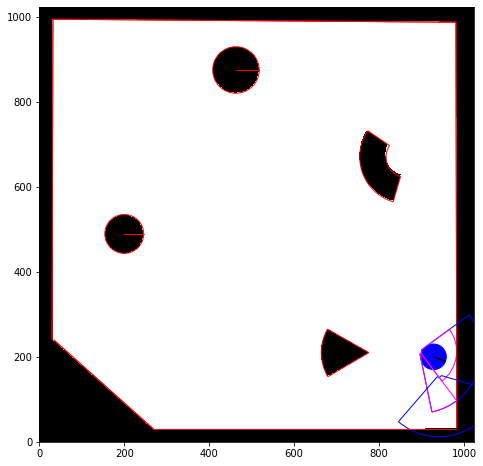

In [4]:

#robot = Robot(680,600,0,80,0,1,0)
#robot = Robot(800,800,0.5,100,0,1,0)
#robot = Robot(379.4084003997459, 907.8212642902986, 0.1308996938995747,80,0,1,0)
#robot = Robot(600,900,3.14,80,0,1,0)
robot = Robot(928.2657448644608,200.15206983924787,5.916297857297023,80,0,1,0)
#robot = Robot(800,770,4.5,80,0,1,0)
#robot = Robot(400,400,0,100,0,1,0)
robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
#     obsa = obstacle
#     I = robot.interval
#     I.interval_analysis(obsa,5,5).draw(ax,"magenta")
    obstacle.draw(ax,'red')
#     del obsa
#     del I
robot.plot(ax)
robot.plot_interval(ax)

# print(robot.interval.gamma2.encloses(Point(obstacles[1].origin)))
# print("\n",obstacles[1].gamma2.encloses(Point(robot.interval.gamma2.origin)))
#robot.interval.fast_analysis(obstacles[1]).draw

# inters = intersection(robot.interval.gamma2.circle,obstacles[1].gamma2.circle)
# for inter in inters:
#     print(robot.interval.gamma2.encloses(inter))
#     print(obstacles[1].gamma2.encloses(inter))
#log = []
for i in range(1):

    
    pose,_ = robot.next_bot(1,1,ax)
    
    print("run:",i)
    #log.append(f'run {i} :'+repr(pose.interval))
    #pose.plot(ax)
    pose.plot_interval(ax)
    print(pose.interval)
    #robot = pose
    
    
#     for I in pose.Is:
#         I.draw(ax,'green')
    

# robot.collision_detection()


# pose1 = pose.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)
# pose1 = pose1.next_bot()
# pose1.plot(ax)
# pose1.plot_interval(ax)

# i = 0
# traj = []
# for pose in robot:
#     i+=1
#     for obstacle in obstacles:
#         obstacle.draw(ax,'red')
#     traj.append((pose.x_bot,pose.y_bot))    
#     pose.plot(ax)
#     pose.plot_interval(ax)
#     del pose
#     if i == 4:
#         break

# path = np.array(traj).T    
# ax.plot(path[0],path[1],'y-')

        ######################################################   patch up

In [23]:
print(log)

['run 0 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(896.4945584806408, 695.1789087090278))', 'run 1 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(893.7814051086044, 604.6386795370966))', 'run 2 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(866.0524591257614, 518.4064358320495))', 'run 3 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(863.3393057537251, 427.86620666011805))', 'run 4 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(891.7055243000477, 331.9737791938042))', 'run 5 :Interval(5.651830281584495,165.6518302815845,3.083702142702977,5.083702142702977,(863.9765783172047, 245.7415354887572))', 'run 6 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(861.2634249451684, 155.2013063168258))', 'run 7 :Interval(5.651830281584495,165.6518302815845,4.0,6.0,(889.629643491491, 59.30887885051195))', 'run 8 :Interval(5.651830281584495,165.6518302815845,4.916297857297023,6.916297857297023,(8

In [21]:
'aa' + repr(pose.interval)

'aaInterval(5.651830281584495,165.6518302815845,4.0,6.0,(893.7814051086044, 604.6386795370966))'

In [7]:
print(pose.x_bot,pose.y_bot,pose.yaw)

379.4084003997459 907.8212642902986 0.1308996938995747


In [8]:
robot.interval.theta1 - robot.interval.theta2

4.283185307179586

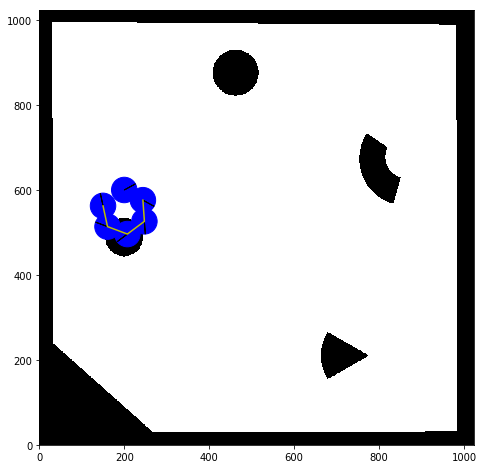

In [11]:
robot = Robot(200,600,0.5,100,0,1,0)

#robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
robot.plot(ax)
#robot.plot_interval(ax)

#log = []
for i in range(5):

    
    pose = robot.next_pose(50,-1)
    
    #print("run:",i)
    #log.append(f'run {i} :'+repr(pose))
    traj.append((pose.x_bot,pose.y_bot))
    pose.plot(ax)

    robot = pose
path = np.array(traj).T    
ax.plot(path[0],path[1],'y-')    

In [16]:
class PurePursuitTracker:
  
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0
        self.goal_threshold = 30

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        if self.ref_idx >= self.length:
            ref_x,ref_y = self.x[-1],self.y[-1]
        else:  
            ref_x,ref_y = self.x[self.ref_idx],self.y[self.ref_idx]
        
        if self.ref_idx > self.length and np.sqrt((ref_x-self.x[-1])**2+ (ref_y-self.y[-1])**2) < self.goal_threshold: 
            return True           
        
        if np.sqrt((ref_x-xc)**2+ (ref_y-yc)**2) < self.lookahead:
            self.ref_idx += 1 
        
        anchor = np.asarray([ref_x - xc, ref_y - yc])

        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        
        X = anchor[0] 
        
        self.w = -2*self.v*X/L/L

        return False
    def revamp(self, xc, yc):
        tracker_xy = np.column_stack((self.x,self.y))
        curr_xy = np.array([xc,yc])
        mina = 0
        mind = np.inf
        veclis = tracker_xy-curr_xy
        for i in range(len(veclis)):
            d = np.linalg.norm(veclis[i])
            if d<mind:
                mind = d    
                mina = i
                
        self.x = self.x[mina:]
        self.y = self.y[mina:]
        print(self.x,self.y)
        self.ref_idx = 0
        self.length = len(self.x)
            
            
        
        
        

In [10]:
t = np.array([1,2,3,5,6,78,8,9])
t[1:]

array([ 2,  3,  5,  6, 78,  8,  9])

[200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200.] [692. 680. 668. 656. 644. 632. 620. 608. 596. 584. 572. 560. 548. 536.
 524. 512. 500. 488. 476. 464. 452. 440. 428. 416. 404. 392. 380. 368.
 356. 344. 332. 320. 308. 296. 284. 272. 260. 248. 236. 224. 212. 200.
 188. 176. 164. 152.]
ARRIVED!!


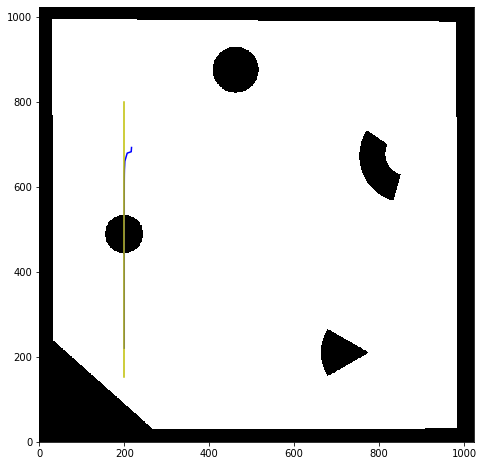

In [21]:
robot = Robot(210,700,-0.78,13,0,0,0)

#robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
path = np.array([[200,800-i*12,np.pi/2] for i in range(55)])
x,y,t = path.T
tracker = PurePursuitTracker(x,y,10,lookahead=80.0) 
pose = [200, 200, np.pi/2] #arbitrary initial pose
#robot.plot(ax)
i = 0
while True:
    #print("v = ",tracker.v," w = ",tracker.w)
    next_bot = robot.next_pose(tracker.v,tracker.w)
    pose = [next_bot.x_bot,next_bot.y_bot,next_bot.yaw]
    if i ==0 :
        tracker.revamp(pose[0],pose[1])
    #next_bot.plot(ax)
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx]) 
    robot = next_bot
    i+=1
    if i == 100:
        break
traced = np.array(traj).T    
ax.plot(traced[0],traced[1],'b-') 
path = np.array(path).T    
ax.plot(path[0],path[1],'y-')  

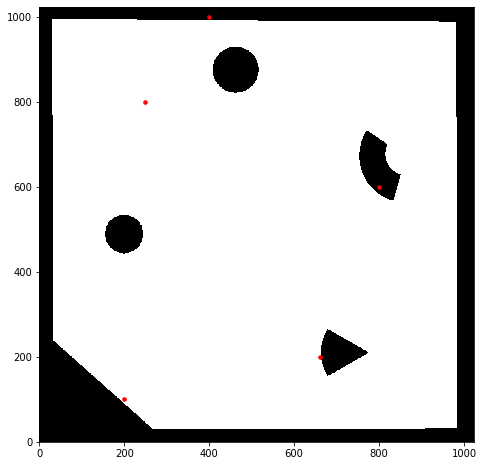

In [37]:
A = (250,800)
B = (200,100)
C = (660,200)
D = (800,600)
E = (400,1000)
fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
ax.scatter(*A,marker='.',color = 'red',s=50)
ax.scatter(*B,marker='.',color = 'red',s=50)
ax.scatter(*C,marker='.',color = 'red',s=50)
ax.scatter(*D,marker='.',color = 'red',s=50)
ax.scatter(*E,marker='.',color = 'red',s=50)
 

In [6]:

def get_line(start, end):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    pts = []    
    for i in range(len(points)):
        if not i%50:
            pts.append(points[i])
            
    slop = Segment(start,end).slope
    if slop is Segment((0,0),(0,1)).slope:
        s = np.arctan(float(slop)*(end[1]-start[1]))
    else:
        s = np.arctan(float(slop))
    thetas = s*np.ones((len(pts),1)) 
    poses = np.append(np.array(pts),thetas,axis=1)
    
    return poses

In [95]:
BA = get_line(B,A)
len(BA)

15

In [39]:
AB = get_line(A,B)
BC = get_line(B,C)

CD = get_line(C,D)
DE = get_line(D,E)

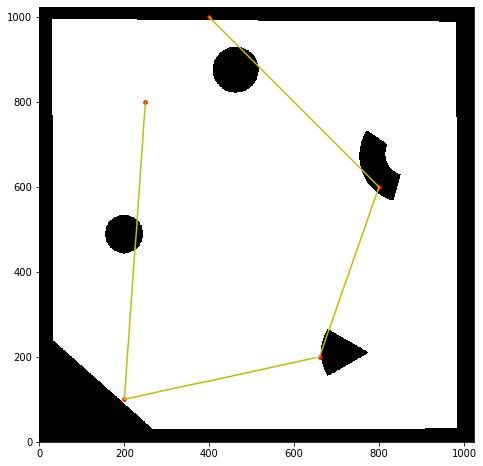

In [40]:
fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
ax.scatter(*A,marker='.',color = 'red',s=50)
ax.scatter(*B,marker='.',color = 'red',s=50)
ax.scatter(*C,marker='.',color = 'red',s=50)
ax.scatter(*D,marker='.',color = 'red',s=50)
ax.scatter(*E,marker='.',color = 'red',s=50)

ax.plot(AB.T[0],AB.T[1],'y-') 
ax.plot(BC.T[0],BC.T[1],'y-') 
ax.plot(CD.T[0],CD.T[1],'y-') 
ax.plot(DE.T[0],DE.T[1],'y-') 

In [7]:
AA = (200,600)
BB = (200,300)
AABB = get_line(AA,BB)

In [8]:
from IPython.display import clear_output

no collision


AttributeError: 'tuple' object has no attribute 'x_bot'

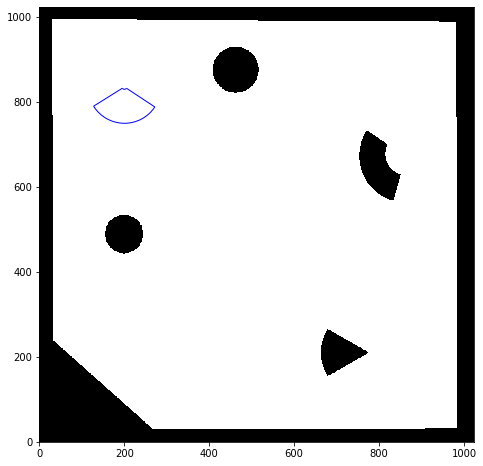

In [12]:
full = np.concatenate((AB,BC,CD,DE),axis=0)
robot = Robot(*A,4.7,20,0,1,0)

robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
path = full #PQ #np.array([[200,800-i*12,np.pi/2] for i in range(55)])
x,y,t = path.T
tracker = PurePursuitTracker(x,y,20,lookahead=50) 
pose = [robot.x_bot,robot.y_bot,robot.yaw] #arbitrary initial pose
# robot.plot(ax)
robot.plot_interval(ax)
i = 0
while True:
    try:
        #print("v = ",tracker.v," w = ",tracker.w)

        #nex_bot = robot.next_bot(tracker.v,tracker.w,ax)
        #nex_bot = robot.next_pose(tracker.v,tracker.w)
        pose = [nex_bot.x_bot,nex_bot.y_bot,nex_bot.yaw]
        #nex_bot.plot(ax)
        #nex_bot.plot_interval(ax)
        if tracker.update(*pose): 
            print("ARRIVED!!")    
            break
        traj.append([*pose, tracker.w, tracker.ref_idx]) 
        robot = nex_bot
        i+=1
        print("run : ",i)
        if i == 150:
            break
    except KeyboardInterrupt:
        break
plt.annotate("A",A)
plt.annotate("B",B)        
traced = np.array(traj).T    
ax.plot(traced[0],traced[1],'b-') 
path = np.array(path).T    
ax.plot(path[0],path[1],'y-')  


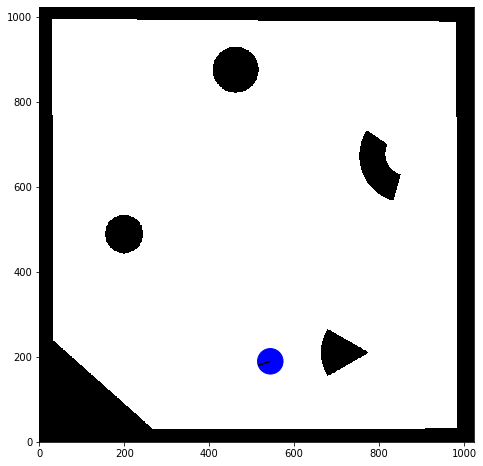

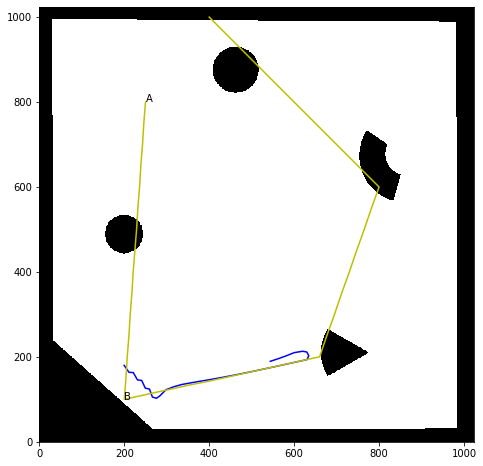

In [44]:
#full = np.concatenate((AB,BC,CD,DE),axis=0)
# AA = (250,600)
# BB = (0,600)
# AABB = get_line(AA,BB)

full = np.concatenate((AB,BC,CD,DE),axis=0)
robot = Robot(*(200,200),4.7,20,0,1,0)

#robot = Robot(*(250,600),3.14,20,0,1,0)

robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
path = full #AABB #PQ #np.array([[200,800-i*12,np.pi/2] for i in range(55)])
x,y,t = path.T
tracker = PurePursuitTracker(x,y,20,lookahead=80) 
pose = [robot.x_bot,robot.y_bot,robot.yaw] #arbitrary initial pose
# robot.plot(ax)
robot.plot_interval(ax)
i = 0
while True:
    try:
        #print("v = ",tracker.v," w = ",tracker.w)

          
#         plt.clf()
        clear_output(wait = True)
        fig,ax = plt.subplots(figsize=(8,8))
        ax. set_aspect('equal')
        ax.set_xlim([0, 1024])
        ax.set_ylim([0, 1024])
        ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        
        robot.plot(ax)
        nex_bot,is_collide = robot.next_bot(tracker.v,tracker.w,ax)
        pose = [nex_bot.x_bot,nex_bot.y_bot,nex_bot.yaw]
        
        #nex_bot = robot.next_pose(tracker.v,tracker.w)
        #nex_bot.plot_interval(ax)
        #print(is_collide)
        if is_collide or i==0:
            tracker.revamp(pose[0],pose[1])
            
        if tracker.update(*pose): 
            print("ARRIVED!!")    
            break
        traj.append([*pose, tracker.w, tracker.ref_idx]) 
        robot = nex_bot
        i+=1
        print("run : ",i)
        if i == 150:
            break
        plt.show()
        #plt.pause(0.5)    
    except KeyboardInterrupt:
        try:
            break
        except GeometryError:
            break
        
clear_output(wait = True)    
fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')

plt.annotate("A",A)
plt.annotate("B",B)        
traced = np.array(traj).T    
ax.plot(traced[0],traced[1],'b-') 
path = np.array(path).T    
ax.plot(path[0],path[1],'y-')
plt.show()


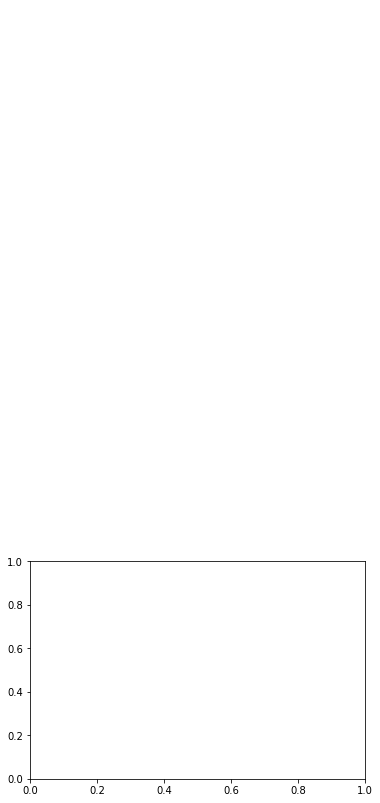

In [55]:
plt.annotate("A",A)
plt.annotate("B",B)        
traced = np.array(traj).T    
ax.plot(traced[0],traced[1],'b-') 
path = np.array(path).T 

ARRIVED!!


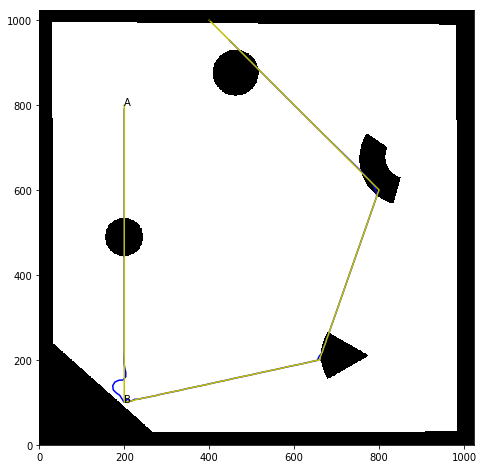

In [166]:
total_path = np.concatenate((AB,BC,CD,DE),axis=0)
robot = Robot(*A,-np.pi/2,1,0,0,0)

#robot.set_environment(obstacles)


fig,ax = plt.subplots(figsize=(8,8))
ax. set_aspect('equal')
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
path = total_path #np.array([[200,800-i*12,np.pi/2] for i in range(55)])
x,y,t = path.T
tracker = PurePursuitTracker(x,y,10,lookahead=80.0) 
pose = [robot.x_bot,robot.y_bot,robot.yaw] #arbitrary initial pose
#robot.plot(ax)
i = 0
while True:
    #print("v = ",tracker.v," w = ",tracker.w)
    next_bot = robot.next_pose(tracker.v,tracker.w)
    pose = [next_bot.x_bot,next_bot.y_bot,next_bot.yaw]
    #next_bot.plot(ax)
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx]) 
    robot = next_bot
    i+=1
    if i == 1000:
        break
plt.annotate("A",A)
plt.annotate("B",B) 
plt.annotate("A",C)
plt.annotate("B",D)
plt.annotate("A",E)

traced = np.array(traj).T    
ax.plot(traced[0],traced[1],'b-') 
path = np.array(path).T    
ax.plot(path[0],path[1],'y-') 

In [156]:
len(BC)

47

In [144]:
A

(200, 800)

In [128]:
len(BC)

461

In [73]:
np.array(get_line((200,800),(200,200)))

array([[200, 800],
       [200, 799],
       [200, 798],
       ...,
       [200, 202],
       [200, 201],
       [200, 200]])

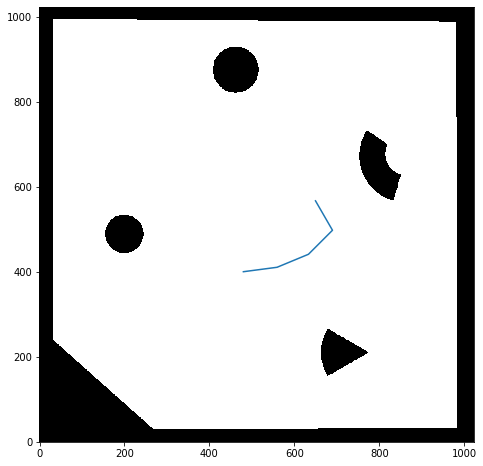

In [26]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
tracker = PurePursuitTracker(x,y,vmax) 
p = np.array(traj).T    
ax.plot(p[0],p[1])
        

In [ ]:
x,y,t = 
tracker = PurePursuitTracker(x,y,vmax) 
pose = 0, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting

traj = []
while True:
    print("v = ",tracker.v," w = ",tracker.w)
    pose = simulate_unicycle(pose,tracker.v,tracker.w)

    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx]) 